In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Dict, List, Optional, Tuple
from dataclasses import dataclass

In [6]:
@dataclass
class Clinic:
    """Класс для представления данных о клинике"""
    code: str
    name: str
    visits: int
    specialties: Dict[str, int]
    
    def get_top_specialties(self, n: int = 5) -> List[Dict[str, int]]:
        """Возвращает топ-N специализаций по количеству посещений"""
        sorted_specialties = sorted(
            self.specialties.items(), 
            key=lambda x: x[1], 
            reverse=True
        )
        return [{"specialty": k, "visits": v} for k, v in sorted_specialties[:n]]

In [7]:
class ClinicDataProcessor:
    """Класс для обработки данных о клиниках"""
    
    def __init__(self, file_path: str):
        """
        Инициализация процессора данных
        
        :param file_path: путь к файлу Excel с данными
        """
        self.file_path = Path(file_path)
        self.clinics: Dict[str, Clinic] = {}
        
    def load_data(self) -> None:
        """Загрузка и обработка данных из файла"""
        if not self.file_path.exists():
            raise FileNotFoundError(f"Файл не найден: {self.file_path}")
            
        # Загрузка данных о клиниках (первый лист)
        clinics_df = pd.read_excel(
            self.file_path, 
            sheet_name="код актива",
            usecols=["Клиника посещения. Код", "Клиника посещения. Название", "Посещений"]
        )
        
        # Загрузка данных о специализациях (второй лист)
        specialties_df = pd.read_excel(
            self.file_path, 
            sheet_name="код актива+ специальность",
            usecols=["Клиника посещения. Код", "Клиника посещения. Название", 
                     "Специализация", "Посещений в июне"]
        )
        
        # Создание объектов Clinic
        for _, row in clinics_df.iterrows():
            code = row["Клиника посещения. Код"]
            name = row["Клиника посещения. Название"]
            visits = row["Посещений"]
            
            # Получаем специализации для этой клиники
            clinic_specialties = specialties_df[specialties_df["Клиника посещения. Код"] == code]
            specialties = {}
            
            for _, spec_row in clinic_specialties.iterrows():
                specialty = spec_row["Специализация"]
                # Пропускаем пустые специализации
                if pd.notna(specialty):
                    specialties[specialty] = spec_row["Посещений в июне"]
            
            self.clinics[code] = Clinic(
                code=code,
                name=name,
                visits=visits,
                specialties=specialties
            )
    
    def get_clinic(self, code: str) -> Optional[Clinic]:
        """Получение клиники по коду"""
        return self.clinics.get(code)
    
    def get_total_visits(self) -> int:
        """Общее количество посещений по всем клиникам"""
        return sum(clinic.visits for clinic in self.clinics.values())
    
    def get_clinics_by_visits(self, min_visits: int = 0) -> List[Clinic]:
        """Получение клиник с количеством посещений больше min_visits"""
        return [
            clinic for clinic in self.clinics.values() 
            if clinic.visits >= min_visits
        ]
    
    def get_top_clinics(self, n: int = 10) -> List[Dict[str, int]]:
        """Топ-N клиник по количеству посещений"""
        sorted_clinics = sorted(
            self.clinics.values(), 
            key=lambda x: x.visits, 
            reverse=True
        )
        return [
            {"code": clinic.code, "name": clinic.name, "visits": clinic.visits}
            for clinic in sorted_clinics[:n]
        ]
    
    def get_specialty_stats(self) -> Dict[str, int]:
        """Статистика по специализациям (суммарное количество посещений)"""
        stats = {}
        for clinic in self.clinics.values():
            for specialty, visits in clinic.specialties.items():
                if specialty in stats:
                    stats[specialty] += visits
                else:
                    stats[specialty] = visits
        return stats
    
    def get_top_specialties(self, n: int = 10) -> List[Dict[str, int]]:
        """Топ-N специализаций по количеству посещений"""
        stats = self.get_specialty_stats()
        sorted_stats = sorted(stats.items(), key=lambda x: x[1], reverse=True)
        return [{"specialty": k, "visits": v} for k, v in sorted_stats[:n]]
    
    def save_to_excel(self, output_path: str) -> bool:
        """Сохраняет результаты анализа в Excel файл"""
        try:
            output_path = Path(output_path)
            output_path.parent.mkdir(parents=True, exist_ok=True)
            
            # Создаем Excel writer
            with pd.ExcelWriter(output_path, engine='openpyxl') as writer:
                # Сохраняем топ клиник
                top_clinics = self.get_top_clinics()
                pd.DataFrame(top_clinics).to_excel(
                    writer, 
                    sheet_name="Топ клиник", 
                    index=False
                )
                
                # Сохраняем топ специализаций
                top_specialties = self.get_top_specialties()
                pd.DataFrame(top_specialties).to_excel(
                    writer, 
                    sheet_name="Топ специализаций", 
                    index=False
                )
                
                # Сохраняем детализацию по клиникам
                clinic_details = []
                for clinic in self.clinics.values():
                    clinic_details.append({
                        "Код": clinic.code,
                        "Название": clinic.name,
                        "Посещений": clinic.visits,
                        "Количество специализаций": len(clinic.specialties)
                    })
                pd.DataFrame(clinic_details).to_excel(
                    writer, 
                    sheet_name="Все клиники", 
                    index=False
                )
                
                # Сохраняем детализацию по специализациям для топ клиник
                for clinic in self.get_top_clinics(10):
                    clinic_obj = self.get_clinic(clinic["code"])
                    if clinic_obj:
                        specialties = clinic_obj.get_top_specialties(10)
                        pd.DataFrame(specialties).to_excel(
                            writer,
                            sheet_name=f"Специализации {clinic['code']}",
                            index=False
                        )
            
            print(f"Файл успешно сохранен: {output_path}")
            return True
        except Exception as e:
            print(f"Ошибка при сохранении файла: {str(e)}")
            return False

In [8]:
class ClinicVisualizer:
    """Класс для визуализации данных о клиниках и специализациях"""
    
    def __init__(self, processor: ClinicDataProcessor):
        """
        Инициализация визуализатора
        
        :param processor: экземпляр ClinicDataProcessor с загруженными данными
        """
        self.processor = processor
    
    def plot_top_clinics_with_specialties(self, n_clinics: int = 5, n_specialties: int = 3, 
                                        save_path: Optional[str] = None) -> None:
        """
        Визуализация топ-N клиник с их топ-M специализациями
        
        :param n_clinics: количество топ клиник для отображения
        :param n_specialties: количество топ специализаций для каждой клиники
        :param save_path: путь для сохранения графика (если None - не сохранять)
        """
        top_clinics = self.processor.get_top_clinics(n_clinics)
        
        plt.figure(figsize=(14, 8))
        
        # Создаем данные для графика
        clinic_names = []
        specialty_data = {}
        colors = plt.cm.tab20.colors  # Используем цветовую палитру
        
        for clinic in top_clinics:
            clinic_obj = self.processor.get_clinic(clinic["code"])
            if clinic_obj:
                clinic_names.append(clinic_obj.name)
                top_specs = clinic_obj.get_top_specialties(n_specialties)
                
                for spec in top_specs:
                    if spec["specialty"] not in specialty_data:
                        specialty_data[spec["specialty"]] = []
                    specialty_data[spec["specialty"]].append(spec["visits"])
        
        # Создаем stacked bar chart
        bottom = None
        
        for i, (specialty, visits) in enumerate(specialty_data.items()):
            if bottom is None:
                plt.bar(clinic_names, visits, label=specialty, color=colors[i % len(colors)])
                bottom = visits
            else:
                plt.bar(clinic_names, visits, bottom=bottom, label=specialty, 
                        color=colors[i % len(colors)])
                bottom = [b + v for b, v in zip(bottom, visits)]
        
        plt.title(f"Топ-{n_clinics} клиник с их топ-{n_specialties} специализациями")
        plt.xlabel("Клиники")
        plt.ylabel("Количество посещений")
        plt.xticks(rotation=45, ha="right")
        plt.legend(title="Специализации", bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"График сохранен: {save_path}")
        
        plt.show()
    
    def plot_specialties_distribution(self, top_n: int = 10, save_path: Optional[str] = None) -> None:
        """
        Визуализация распределения топ-N специализаций
        
        :param top_n: количество специализаций для отображения
        :param save_path: путь для сохранения графика (если None - не сохранять)
        """
        top_specialties = self.processor.get_top_specialties(top_n)
        
        plt.figure(figsize=(12, 6))
        
        specialties = [spec["specialty"] for spec in top_specialties]
        visits = [spec["visits"] for spec in top_specialties]
        
        bars = plt.barh(specialties[::-1], visits[::-1], color=plt.cm.tab20.colors)
        
        plt.title(f"Топ-{top_n} специализаций по количеству посещений")
        plt.xlabel("Количество посещений")
        plt.ylabel("Специализация")
        
        # Добавляем значения на столбцы
        for bar in bars:
            width = bar.get_width()
            plt.text(width + max(visits)*0.01, bar.get_y() + bar.get_height()/2,
                     f'{int(width)}', va='center')
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"График сохранен: {save_path}")
        
        plt.show()

In [9]:
class ClinicVisualizer:
    """Класс для визуализации данных о клиниках и специализациях"""
    
    def __init__(self, processor: ClinicDataProcessor):
        self.processor = processor
    
    def plot_top_clinics_with_specialties(self, n_clinics: int = 5, n_specialties: int = 3, 
                                        save_path: Optional[str] = None) -> None:
        """
        Визуализация топ-N клиник с их топ-M специализациями
        
        :param n_clinics: количество топ клиник для отображения
        :param n_specialties: количество топ специализаций для каждой клиники
        :param save_path: путь для сохранения графика
        """
        top_clinics = self.processor.get_top_clinics(n_clinics)
        
        plt.figure(figsize=(14, 8))
        
        # Собираем данные для графика
        data = []
        clinic_names = []
        
        for clinic in top_clinics:
            clinic_obj = self.processor.get_clinic(clinic["code"])
            if clinic_obj:
                clinic_names.append(clinic_obj.name)
                top_specs = clinic_obj.get_top_specialties(n_specialties)
                data.append({spec["specialty"]: spec["visits"] for spec in top_specs})
        
        # Преобразуем в DataFrame для удобства
        df = pd.DataFrame(data, index=clinic_names)
        df = df.fillna(0)  # Заполняем пропуски нулями
        
        # Строим stacked bar chart
        ax = df.plot(kind='bar', stacked=True, figsize=(14, 8), colormap='tab20')
        
        plt.title(f"Топ-{n_clinics} клиник с их топ-{n_specialties} специализациями")
        plt.xlabel("Клиники")
        plt.ylabel("Количество посещений")
        plt.xticks(rotation=45, ha="right")
        plt.legend(title="Специализации", bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"График сохранен: {save_path}")
        
        plt.show()
    
    def plot_specialties_distribution(self, top_n: int = 10, save_path: Optional[str] = None) -> None:
        """
        Визуализация распределения топ-N специализаций
        
        :param top_n: количество специализаций для отображения
        :param save_path: путь для сохранения графика
        """
        top_specialties = self.processor.get_top_specialties(top_n)
        
        plt.figure(figsize=(12, 6))
        
        specialties = [spec["specialty"] for spec in top_specialties]
        visits = [spec["visits"] for spec in top_specialties]
        
        bars = plt.barh(specialties[::-1], visits[::-1], color=plt.cm.tab20.colors)
        
        plt.title(f"Топ-{top_n} специализаций по количеству посещений")
        plt.xlabel("Количество посещений")
        plt.ylabel("Специализация")
        
        # Добавляем значения на столбцы
        for bar in bars:
            width = bar.get_width()
            plt.text(width + max(visits)*0.01, bar.get_y() + bar.get_height()/2,
                    f'{int(width)}', va='center')
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"График сохранен: {save_path}")
        
        plt.show()

Всего клиник: 148
Общее количество посещений: 1297900

Топ-10 клиник по посещениям:
1. Клинико-диагностический центр на Белорусской - 90582 посещений
2. Клинико-диагностический центр на Красной Пресне - 78435 посещений
3. Многофункциональный медицинский центр "Медси" "Мичуринский" - 67730 посещений
4. Клинико-диагностический центр на Солянке - 50299 посещений
5. Клиника на Пречистенке - 41357 посещений
6. Клиника в Хорошевском проезде - 40295 посещений
7. Клиника в Благовещенском переулке - 37992 посещений
8. Клиническая больница в Отрадном №1 - 35947 посещений
9. Клиника на Дубининской - 29531 посещений
10. Клинико-диагностический центр Медси в Выксе - 29247 посещений

Топ-10 специализаций по посещениям:
1. Лаборатория - 173262 посещений
2. Процедурный кабинет - 109080 посещений
3. УЗИ - 105658 посещений
4. Терапия - 75698 посещений
5. Рентгенология - 70709 посещений
6. Гинекология - 66958 посещений
7. Отоларингология - 54583 посещений
8. Неврология - 51865 посещений
9. Функциональная

<Figure size 1400x800 with 0 Axes>

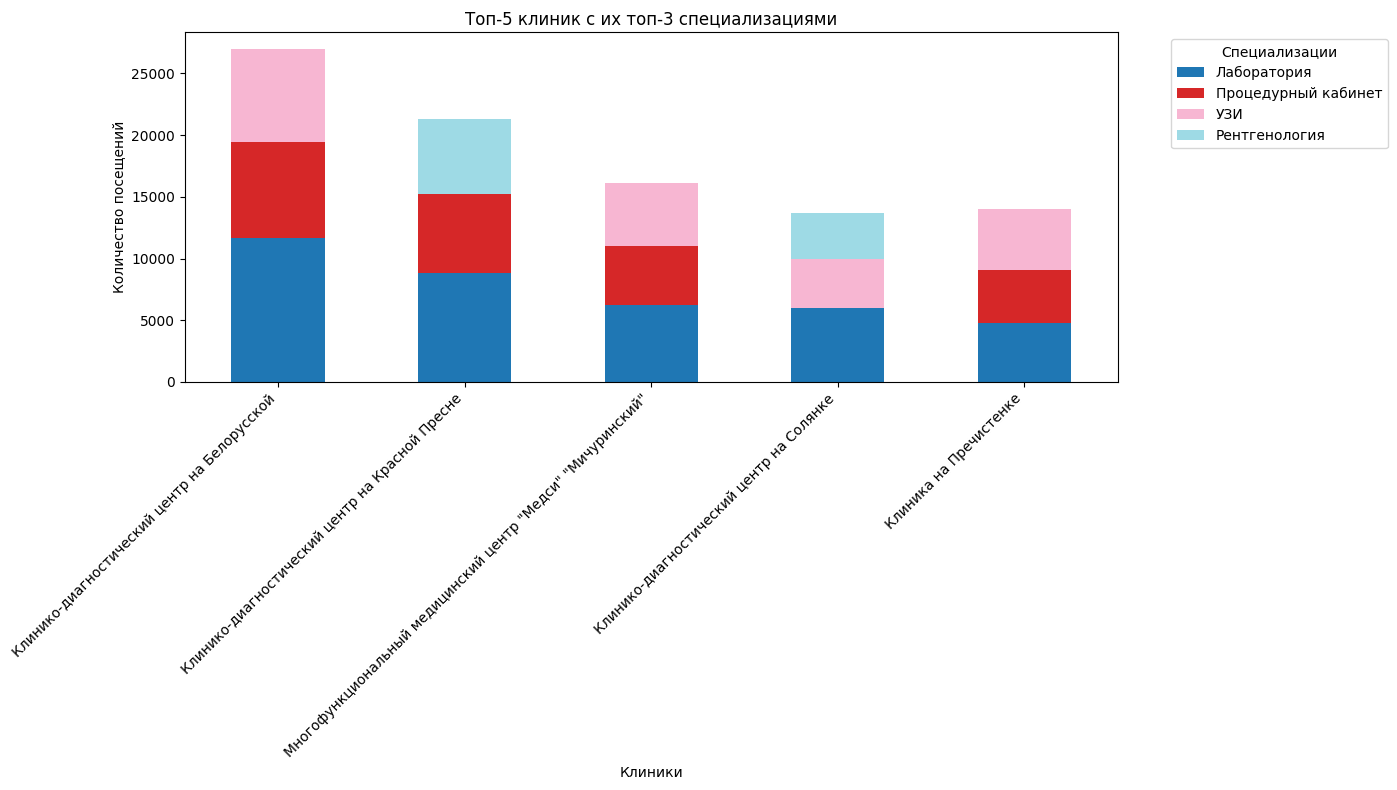

График сохранен: C:\Users\gradov.ki\IDE\top_specialties_distribution.png


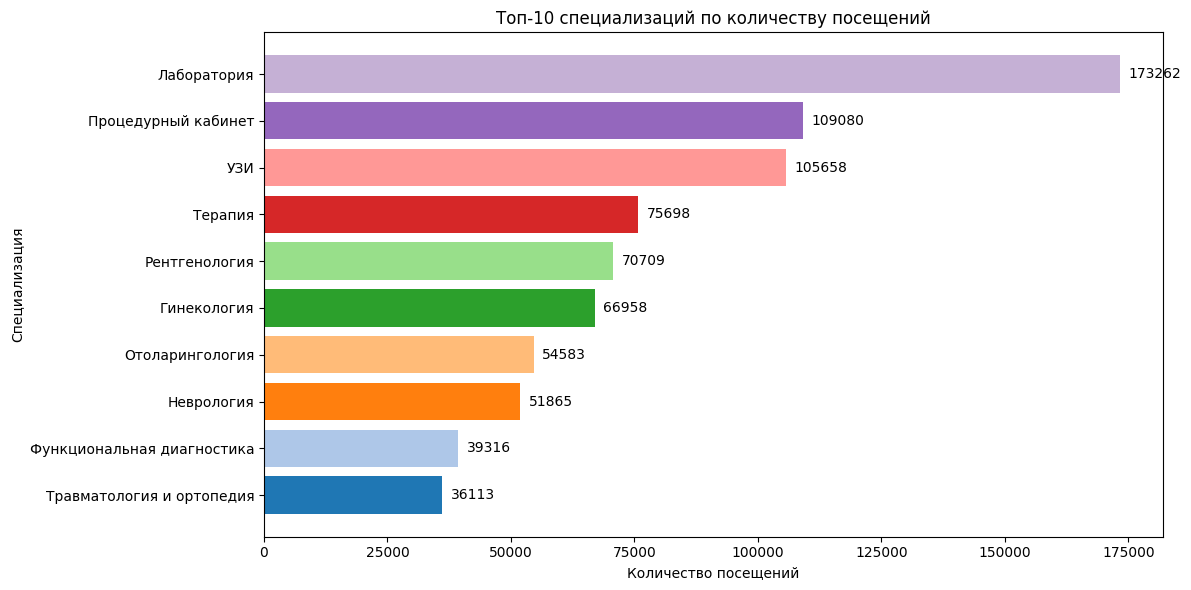

Файл успешно сохранен: C:\Users\gradov.ki\Результаты анализа\Результаты_аналитики_июнь.xlsx
Обработка завершена успешно!


In [10]:
def main():
    # Путь к файлу с данными
    file_path = r"C:\Users\gradov.ki\IDE\Посещения июнь.xlsx"
    output_file = r"C:\Users\gradov.ki\Результаты анализа\Результаты_аналитики_июнь.xlsx"
    
    try:
        # Создаем процессор данных
        processor = ClinicDataProcessor(file_path)
        
        # Загружаем данные
        processor.load_data()
        
        # Примеры использования:
        
        # 1. Общая статистика
        print(f"Всего клиник: {len(processor.clinics)}")
        print(f"Общее количество посещений: {processor.get_total_visits()}")
        
        # 2. Топ клиник
        print("\nТоп-10 клиник по посещениям:")
        for i, clinic in enumerate(processor.get_top_clinics(10), 1):
            print(f"{i}. {clinic['name']} - {clinic['visits']} посещений")
        
        # 3. Топ специализаций
        print("\nТоп-10 специализаций по посещениям:")
        for i, spec in enumerate(processor.get_top_specialties(10), 1):
            print(f"{i}. {spec['specialty']} - {spec['visits']} посещений")
        
        # 4. Пример работы с конкретной клиникой
        clinic_code = "КДЦП"
        clinic = processor.get_clinic(clinic_code)
        if clinic:
            print(f"\nИнформация о клинике {clinic.name} (код: {clinic.code}):")
            print(f"Всего посещений: {clinic.visits}")
            print("Топ-5 специализаций:")
            for i, spec in enumerate(clinic.get_top_specialties(5), 1):
                print(f"{i}. {spec['specialty']} - {spec['visits']} посещений")

        # Визуализация данных
        visualizer = ClinicVisualizer(processor)
        
        # 1. График топ клиник с их специализациями
        visualizer.plot_top_clinics_with_specialties(
            n_clinics=5, 
            n_specialties=3,
            save_path=str(Path(file_path).parent / "top_clinics_with_specialties.png")
        )
        
        # 2. График распределения специализаций
        visualizer.plot_specialties_distribution(
            top_n=10,
            save_path=str(Path(file_path).parent / "top_specialties_distribution.png")
        )
        
        # Сохранение результатов
        if processor.save_to_excel(output_file):
            print("Обработка завершена успешно!")
        else:
            print("Обработка завершена с ошибками при сохранении")
            
    except FileNotFoundError as e:
        print(f"\nОшибка: {str(e)}")
    except ValueError as e:
        print(f"\nОшибка в данных: {str(e)}")
    except Exception as e:
        print(f"\nНеожиданная ошибка: {str(e)}")
    finally:
        input("\nНажмите Enter для выхода...")


if __name__ == "__main__":
    main()